In [ ]:
%load_ext autoreload
%autoreload 
    
import time
import sys
sys.path.insert(0, "../")

from leitmotifs.plotting import *
from leitmotifs.lama import *

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")



def plot_motiflet(series, motiflet, dims, motif_length, title=None):    
    fig, ax = plt.subplots(figsize=(4,2))

    offset = 0.0
    for dim in dims:
        dim_data_raw = pd.DataFrame(data=np.array([series[dim, i:i+motif_length] for i in motiflet]))        
        offset -= 2 * (dim_data_raw.values.max() - dim_data_raw.values.min())
        ax = sns.lineplot(data=dim_data_raw.melt().set_index("variable") + offset)
        
    if title:
        ax.set_title(title)
        
    sns.despine()
    fig.patch.set_visible(False)
    ax.legend().set_visible(False)
    ax.axis('off')
    return fig, ax


def find_dominant_window_sizes(X, offset=0.05):
    """Determine the Window-Size using dominant FFT-frequencies.

    Parameters
    ----------
    X : array-like, shape=[n]
        a single univariate time series of length n
    offset : float
        Exclusion Radius

    Returns
    -------
    trivial_match: bool
        If the candidate change point is a trivial match
    """
    fourier = np.absolute(np.fft.fft(X))
    freqs = np.fft.fftfreq(X.shape[0], 1)

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freqs):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)

    idx = np.argsort(coefs)[::-1]
    return next(
        (
            int(window_size / 2)
            for window_size in window_sizes[idx]
            if window_size in range(20, int(X.shape[0] * offset))
        ),
        window_sizes[idx[0]],
    )

def load_dataset(dataset, selection=None):
    desc_filename = f"../datasets/{dataset}/desc.txt"
    desc_file = []

    with open(desc_filename, 'r') as file:
        for line in file.readlines(): desc_file.append(line.split(","))

    df = []

    for idx, row in enumerate(desc_file):
        if selection is not None and idx not in selection: continue
        (ts_name, window_size), change_points = row[:2], row[2:]
        if len(change_points) == 1 and change_points[0] == "\n": change_points = list()
        path = f'../datasets/{dataset}/'

        if os.path.exists(path + ts_name + ".txt"):
            ts = np.loadtxt(fname=path + ts_name + ".txt", dtype=np.float64)
        else:
            ts = np.load(file=path + "data.npz")[ts_name]

        df.append((ts_name, int(window_size), np.array([int(_) for _ in change_points]), ts))

    return pd.DataFrame.from_records(df, columns=["name", "window_size", "change_points", "time_series"])


In [2]:
dataset = "PAMAP"
# selection = [63, 64, 65] # Indoor
selection = [126, 127, 128]
df_data = load_dataset(dataset)
df_data.head()

,name,window_size,change_points,time_series
0,PAMAP_Indoor_Subject1_IMU_Shoe_X-Acc,100,"[17124, 36563, 54372, 81321, 97438, 106170, 11...","[4.13, 4.17, 4.28, 4.21, 4.17, 4.24, 4.17, 4.2..."
1,PAMAP_Indoor_Subject1_IMU_Shoe_Y-Acc,100,"[17124, 36563, 54372, 81321, 97438, 106170, 11...","[9.03, 8.99, 8.88, 9.1, 8.88, 9.03, 8.99, 8.88..."
2,PAMAP_Indoor_Subject1_IMU_Shoe_Z-Acc,100,"[17124, 36563, 54372, 81321, 97438, 106170, 11...","[-0.06, 0.1, 0.17, 0.14, -0.06, 0.1, -0.02, 0...."
3,PAMAP_Indoor_Subject1_IMU_Shoe_X-Gyro,100,"[17124, 36563, 54372, 81321, 97438, 106170, 11...","[0.02, -0.02, 0.02, 0.02, 0.03, -0.0, 0.02, -0..."
4,PAMAP_Indoor_Subject1_IMU_Shoe_Y-Gyro,100,"[17124, 36563, 54372, 81321, 97438, 106170, 11...","[0.03, 0.01, -0.12, -0.03, -0.01, -0.0, -0.01,..."


In [154]:
ts_name = df_data["name"].iloc[selection]
ts = df_data.time_series.iloc[selection]
cps = df_data.change_points.iloc[selection[0]]

X = np.zeros((len(ts.values), len(ts.values[0])))
for i, data in enumerate(ts.values):
    X[i] = data

cps = np.concatenate([[0], cps, [X.shape[1]]])

series = pd.DataFrame(data=X, index=ts_name)
series.rename(index={'PAMAP_Outdoor_Subject8_IMU_Shoe_X-Acc': 'Shoe X-Acc', 
                              'PAMAP_Outdoor_Subject8_IMU_Shoe_Y-Acc': 'Shoe Z-Acc', 
                              'PAMAP_Outdoor_Subject8_IMU_Shoe_Z-Acc': 'Shoe Y-Acc'}, inplace=True)
series

,0,1,2,3,4,5,6,7,8,9,...,173865,173866,173867,173868,173869,173870,173871,173872,173873,173874
name,,,,,,,,,,,,,,,,,,,,,
Shoe X-Acc,-4.56,-4.64,-4.52,-4.60,-4.60,-4.52,-4.64,-4.64,-4.67,-4.67,...,-4.34,-4.45,-4.45,-4.49,-4.67,-4.67,-4.60,-4.49,-4.49,-4.45
Shoe Z-Acc,0.29,0.29,0.25,0.21,0.21,0.25,0.25,0.21,0.25,0.29,...,0.21,0.21,0.14,-0.05,0.21,0.21,0.21,0.10,0.21,0.21
Shoe Y-Acc,8.40,8.32,8.56,8.52,8.40,8.48,8.40,8.44,8.52,8.40,...,8.56,8.48,8.60,8.72,8.48,8.52,8.40,8.56,8.52,8.56


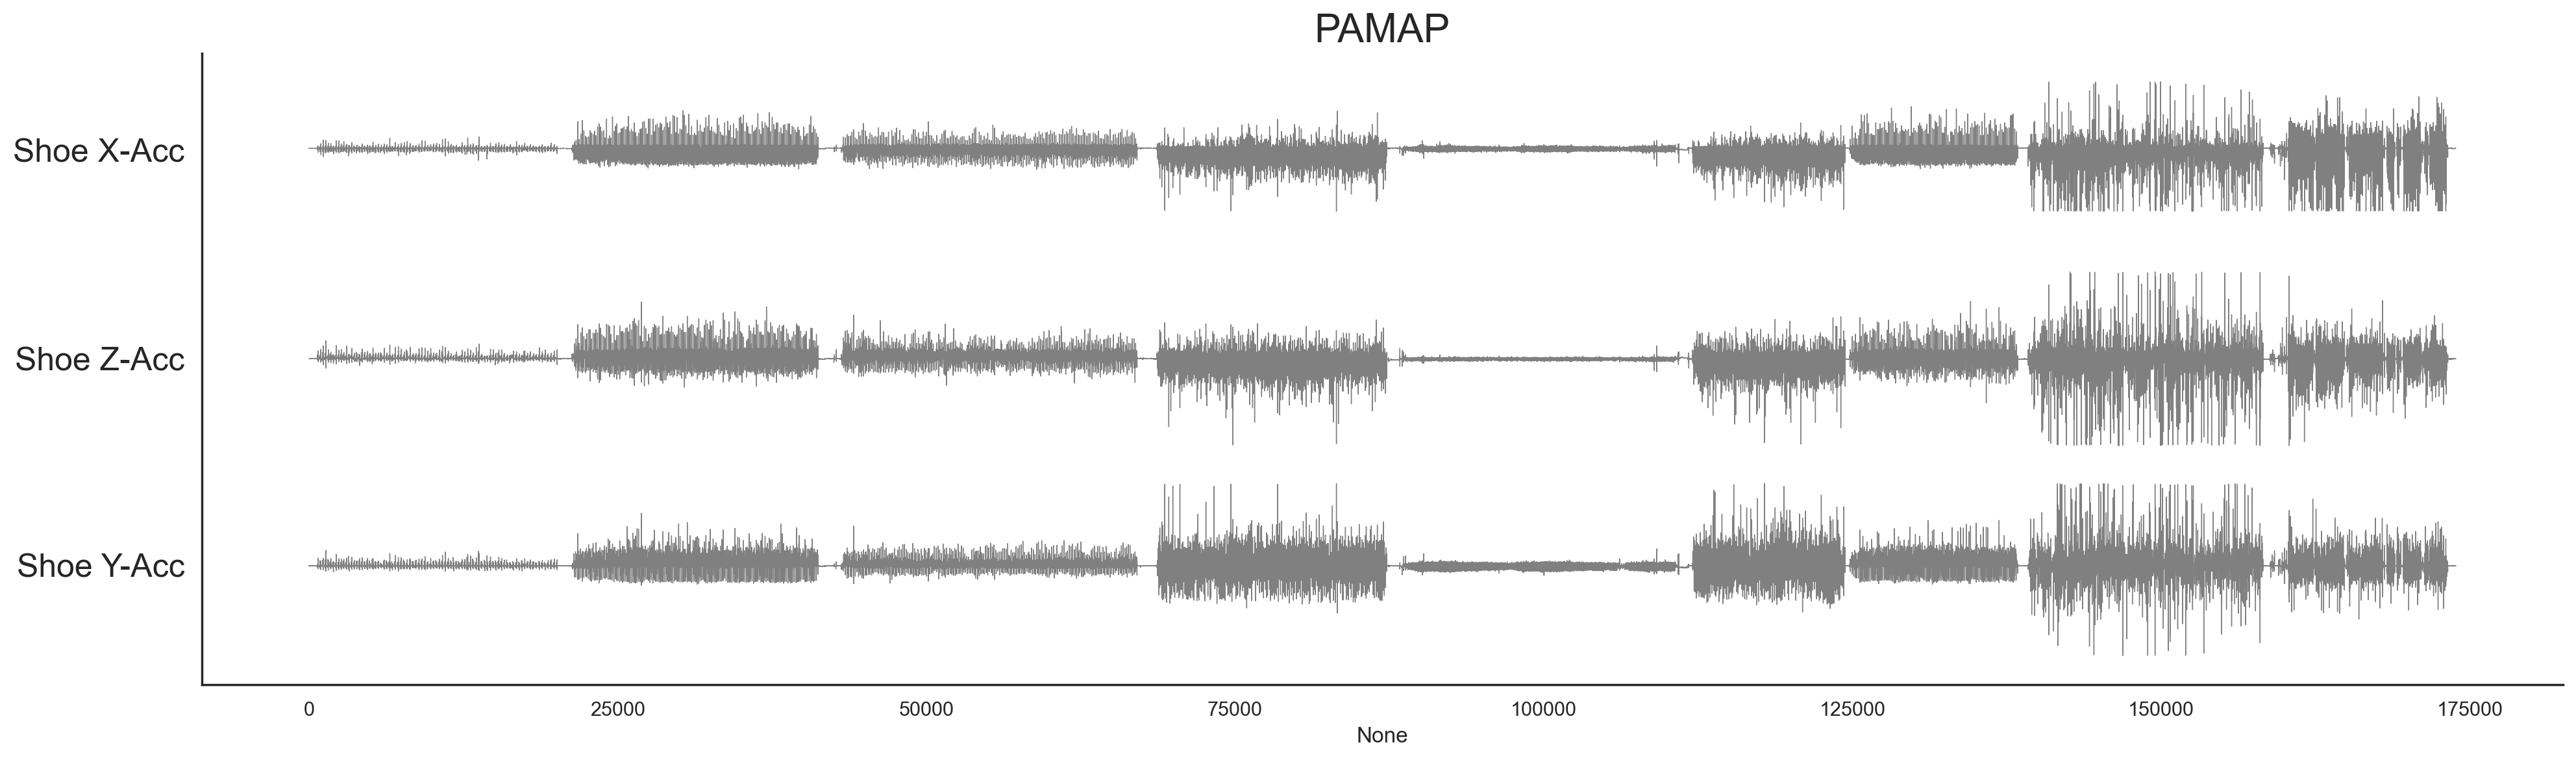

In [155]:
f = 2         
ds_name = "PAMAP"

# initialize LAMA
ml = LAMA(
    ds_name,  
    series,
    dimension_labels=series.index,
    n_dims=f,   # number of sub-dimensions
)

_ = ml.plot_dataset()

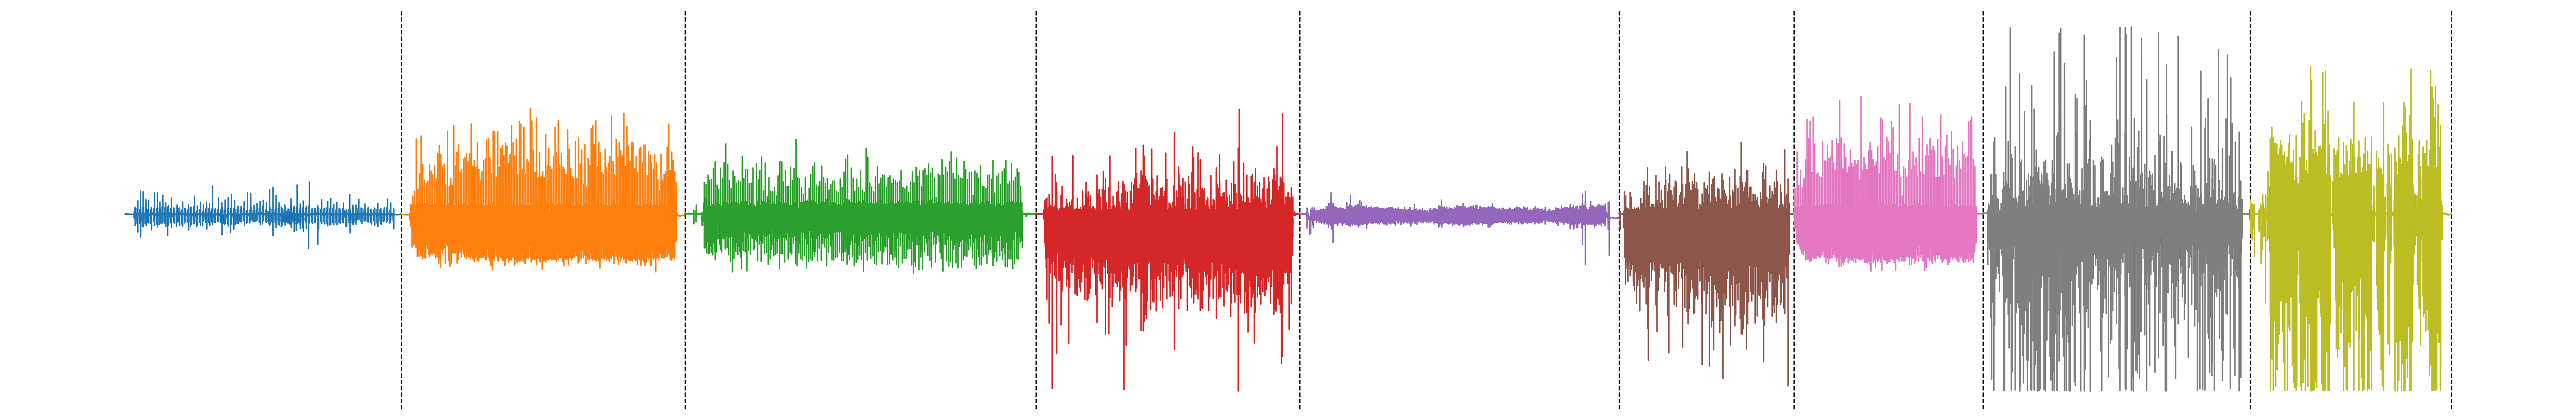

In [49]:
colors = sns.color_palette("tab10")
fix, ax = plt.subplots(figsize=(30, 5))

for i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):
    label = cps[i]      
    c = colors[i % len(colors)]
        
    sns.lineplot(x=np.arange(a,b), linewidth=1,
                 y=series.iloc[0, a:b], ax = ax, label=label,
                 color=c)
    
    ax.axvline(x=b, color="black", linestyle="--", linewidth=1)
    
plt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()
ax.legend().set_visible(False)
ax.axis('off')
plt.tight_layout()

In [6]:
indoor_annotations = ["Lie", "Sit", "Stand", "Iron", "Vacuum", "Ascend Stairs",  "Decend Stairs", "Ascend Stairs", "Ascend Stairs"]

outdoor_annotations = ["Walk very slow", "Normal Walk", "Nordic Walk", "Run", "Cycle", "Run", "Normal Walk", "Soccer", "Rope Jump"]


annotations = outdoor_annotations

# Run ClaSS to determine Segments

In [7]:
#from src.clazz.segmentation import ClaSS
#from benchmark.utils import run_stream

#stream = ClaSS(n_timepoints=10_000, n_prerun=min(10_000, series.shape[0]))
#profile, runtimes, found_cps, found_cps_dx = run_stream(stream, series, aggregate_profile=np.max)
#scores = stream.scores

# Run LAMA on each segment

In [153]:
k_max = 40
max_segment_size = 20000
tic = time.time()

all_motifs = []
for i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):
    #if i < 6:
    #    continue
    print (f"Start {a} End {b}")
    b = min(a + max_segment_size, b)
    data = series.iloc[:, a:b].values

    label = annotations[i]

    # initialize LAMA
    ml = LAMA(
        label,  
        data,
        n_dims=2,    # number of sub-dimensions
        n_jobs=4     # number of parallel jobs
    )
    
    #_ = ml.plot_dataset()
    # break
    
    window_size = 6*find_dominant_window_sizes(data[0], offset=0.05)
    
    dists, motif_sets, elbow_points = ml.fit_k_elbow(
        k_max=k_max,
        motif_length=window_size,
        plot_elbows=False,
        plot_motifsets=False,
    )

    best_dims = ml.leitmotifs_dims

    """
    fig, ax = plot_motiflet(
        data,
        motif_sets[elbow_points[-1]], 
        best_dims[elbow_points[-1]], 
        window_size,
        title=str(i+1) + ". " + label,
    )    
    plt.savefig("images/pamap_"+str(i+1)+"_"+label+".pdf")
    plt.show()
    """
    
    all_motifs.append([i, a, b, label, window_size, motif_sets[elbow_points[-1]], best_dims[elbow_points[-1]]])
    # break

print(f"Total time: {time.time() - tic} sec.")

Start 0 End 20657
Data (3, 20000)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 696 in 31.1 s
Elbow Points [37]
Start 20657 End 41848
Data (3, 20000)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 348 in 18.2 s
Elbow Points [35 38]
Start 41848 End 68082
Data (3, 20000)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 408 in 21.7 s
Elbow Points [29 32 38]
Start 68082 End 87811
Data (3, 19729)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 240 in 6.2 s
Elbow Points [ 3 19 38]
Start 87811 End 111675
Data (3, 20000)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 282 in 36.4 s
Elbow Points [37]
Start 111675 End 124743
Data (3, 13068)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 234 in 3.3 s
Elbow Points [14 37]
Start 124743 End 138876
Data (3, 14133)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 342 in 7.6 s
Elbow Points [39]
Start 138876 End 158863
Data (3, 19987)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 108 in 7.0 s
Elbow Points [39]
Start 158863 End 173875
Data (3, 15012)


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

Chosen window-size: 66 in 5.2 s
Elbow Points [10 38]
Total time: 136.79519319534302 ms.


# Summary

In [145]:
# all_motifs
series.index
y_labels = np.array(["Shoe X-Acc", "Shoe Y-Acc", "Shoe Z-Acc"])

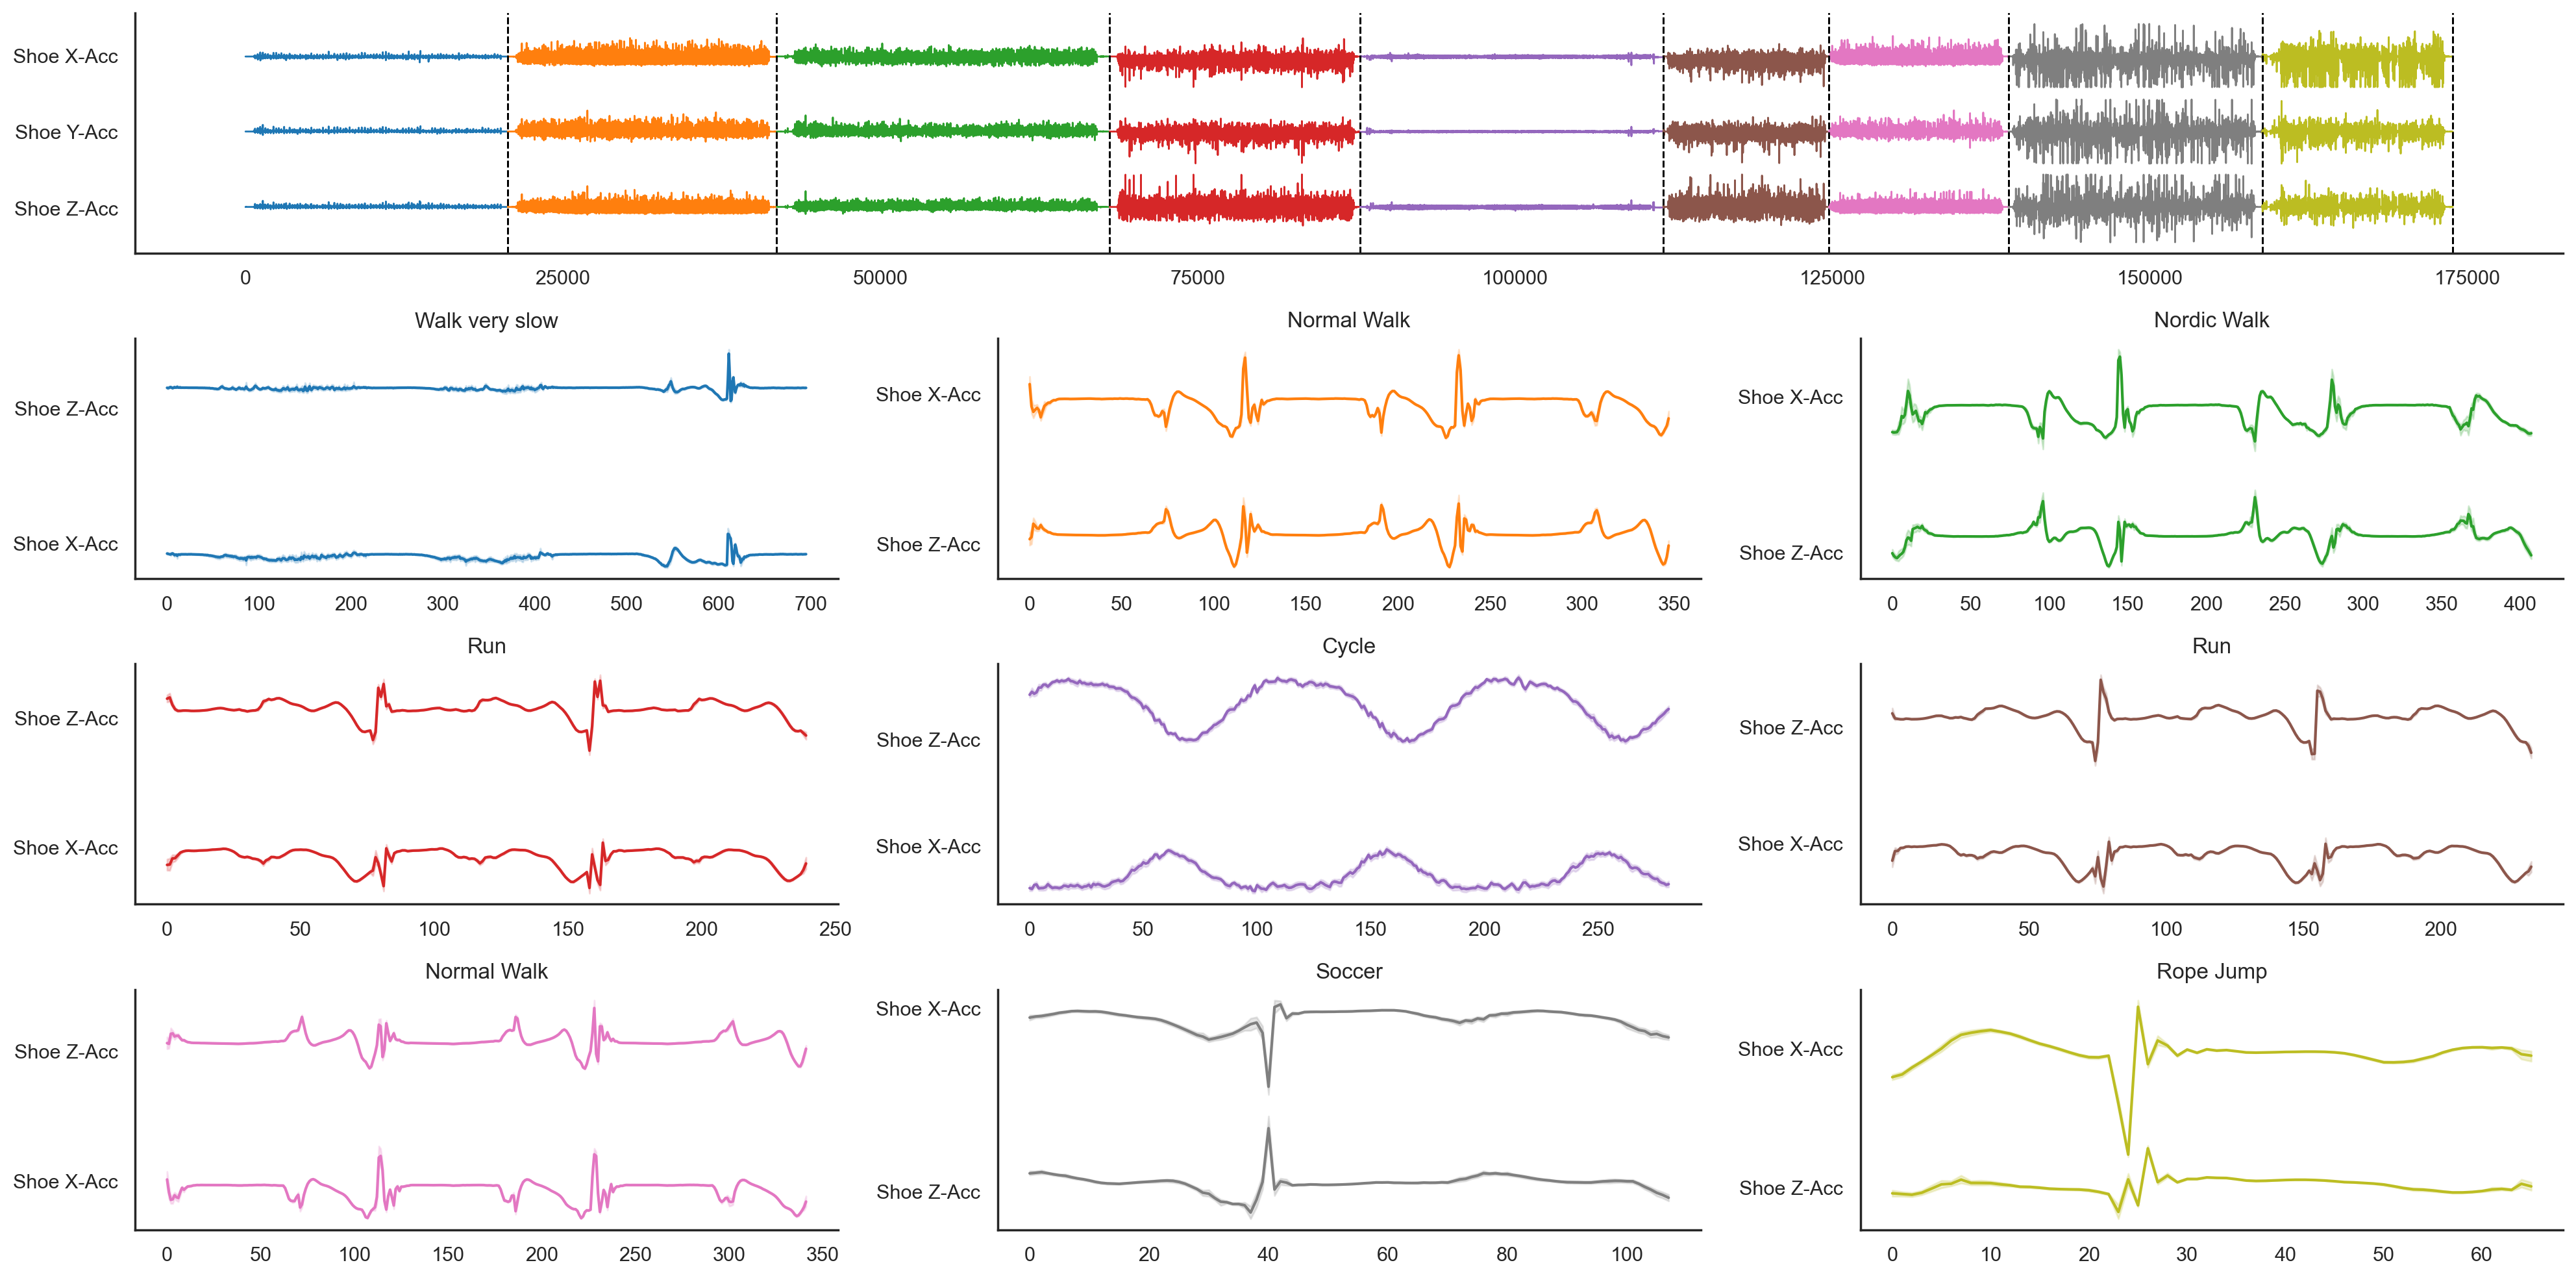

In [152]:
from matplotlib.gridspec import GridSpec
# fix, ax = plt.subplots(figsize=(30, 5))
fig = plt.figure(layout="constrained", figsize=(20, 10))

gs = GridSpec(4, 3, figure=fig)
ax = fig.add_subplot(gs[0, :])

offset = 0.0
tick_offsets = []
for dim in range(series.shape[0]):
    for i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):
        dim_data = series.iloc[dim, a:b]
        c = colors[i % len(colors)]
        sns.lineplot(x=np.arange(a,b), linewidth=1, y=dim_data+offset, ax = ax, label=label, color=c)    
        ax.axvline(x=b, color="black", linestyle="--", linewidth=1)    
    tick_offsets.append(offset)
    offset -= 1.2 * (series.iloc[dim].values.max() - series.iloc[dim].values.min())    

ax.set_yticks(tick_offsets)
ax.set_yticklabels(y_labels)
ax.set_ylabel("")
sns.despine()
ax.legend().set_visible(False)
# ax.axis('off')

for i, a, b, label, motif_size, motifs, dims in all_motifs: 
    c = colors[i % len(colors)]
    # plot_motiflet(series.iloc[:, a:b].values, motifs, dims, motif_size, label, c=c)
    subseries = series.iloc[:, a:b].values
    offset = 0.0    
    y_offsets = []
    ax = fig.add_subplot(gs[i//3+1, i%3])        
    
    for dim in dims:
        dim_data_raw = pd.DataFrame(data=np.array([subseries[dim, x:x+motif_size] for x in motifs]))                
        offset -= (dim_data_raw.values.max() - dim_data_raw.values.min())
        y_offsets.append(offset)
        if not c:
           c = "blue"
        sns.lineplot(data=dim_data_raw.melt().set_index("variable") + offset, palette=[c], ax=ax)                
        
    sns.despine()
    fig.patch.set_visible(False)
    ax.legend().set_visible(False)
    ax.set_yticks(y_offsets)
    ax.set_yticklabels(y_labels[dims])
    # ax.axis('off')        
    ax.set_title(label)
    ax.set_xlabel("")

plt.tight_layout()
plt.savefig("images/har_series_motifs.pdf")